<a href="https://colab.research.google.com/github/krishnakantsingh14/KaggleLiverpool/blob/master/KaggleLiverpool/src/Submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!nvidia-smi

Mon May 25 19:47:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
%tensorflow_version 2.x

In [0]:
import pandas as pd
import numpy as np 
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.preprocessing import minmax_scale, OneHotEncoder
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
from sklearn.metrics import cohen_kappa_score, accuracy_score, mean_squared_error, f1_score

import tensorflow as tf
from tensorflow.keras.layers import *
import pandas as pd
import numpy as np
import random
from tensorflow.keras.callbacks import Callback, LearningRateScheduler
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import backend as K
from tensorflow.keras import losses, models, optimizers
import tensorflow_addons as tfa
import gc

import tensorflow.keras as keras
from sklearn.model_selection import GroupKFold
from sklearn.metrics import f1_score

import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 500)

import os

In [0]:
PATH = '/content/drive/My Drive/Kaggle/ion_data/'


In [0]:
n_units = 32
def doubleGRU(shape):
  input_ = keras.layers.Input(shape = shape)
  gru_h1 = keras.layers.Bidirectional(tf.keras.layers.GRU(n_units, return_sequences=True))(input_)
  gru_h2 = keras.layers.Bidirectional(tf.keras.layers.GRU(n_units, return_sequences=True))(gru_h1)
  input_gru3 = Add()([gru_h1, gru_h2])
  gru_h3 = keras.layers.Bidirectional(tf.keras.layers.GRU(n_units, return_sequences=True))(input_gru3)

  input_dense = Add()([gru_h1, gru_h2, gru_h3])
  output = tf.keras.layers.Dense(11, activation="softmax")(input_dense)
  model = keras.Model(inputs=[input_], outputs=[output])
#   opt = Adam(lr = LR)
#   opt = tfa.optimizers.SWA(opt)
#   model.compile(loss = tfa.losses.sigmoid_focal_crossentropy, optimizer = opt, metrics = ['accuracy'])
  return model

In [0]:
def getpreModel(shape, nfold):
    model_pre = doubleGRU(shape)
    # print (model_pre.summary())
    # model_pre.load_weights(f'{PATH}/tcnshllown_{nfold}.h5')
    features_list = [layer.output for layer in model_pre.layers[:-1]]
    model_on_pre  = keras.Model(inputs=model_pre.input, outputs=features_list[-1])
    # for layer in model_on_pre.layers:
    #     layer.trainable = False
    return model_on_pre






In [0]:
def wave_rnn_net(shape_, nfold):
    
    def wave_block(x, filters, kernel_size, n):
        dilation_rates = [2**i for i in range(n)]
        x = Conv1D(filters = filters,
                   kernel_size = 1,
                   padding = 'same')(x)
        res_x = x
        for dilation_rate in dilation_rates:
            tanh_out = Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same', 
                              activation = 'tanh', 
                              dilation_rate = dilation_rate)(x)
            sigm_out = Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same',
                              activation = 'sigmoid', 
                              dilation_rate = dilation_rate)(x)
            x = Multiply()([tanh_out, sigm_out])
            x = Conv1D(filters = filters,
                       kernel_size = 1,
                       padding = 'same')(x)
            res_x = Add()([res_x, x])
        return res_x
    
    inp = Input(shape = (shape_))
    # inp = Input(shape = (shape_))
    model_pre = getpreModel(shape_,nfold )
    out = model_pre(inp)
    # for layer in model_b.layers:
    #     layer.trainable = False

    x = wave_block(out, 16, 3, 12)
    x = wave_block(x, 32, 3, 8)
    x = wave_block(x, 64, 3, 4)
    # x = wave_block(x, 128, 3, 1)
    x = tf.keras.layers.Concatenate()([x,out])
    x = tf.keras.layers.Dropout(0.4)(x)
    x = Dense(128, activation = 'relu')(x)
    
    out = Dense(11, activation = 'softmax', name = 'out')(x)
    
    model_wave_rnn = models.Model(inputs = inp, outputs = out)
    

    return model_wave_rnn

In [0]:
m = doubleGRU((None,45))

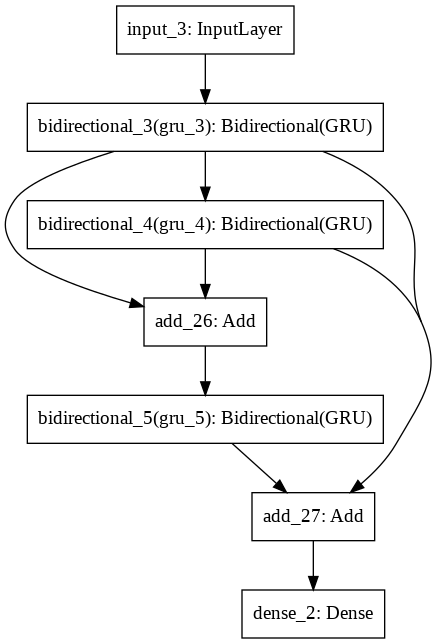

In [0]:
tf.keras.utils.plot_model(m)

In [0]:
t = wave_rnn_net((None, 45), 0)

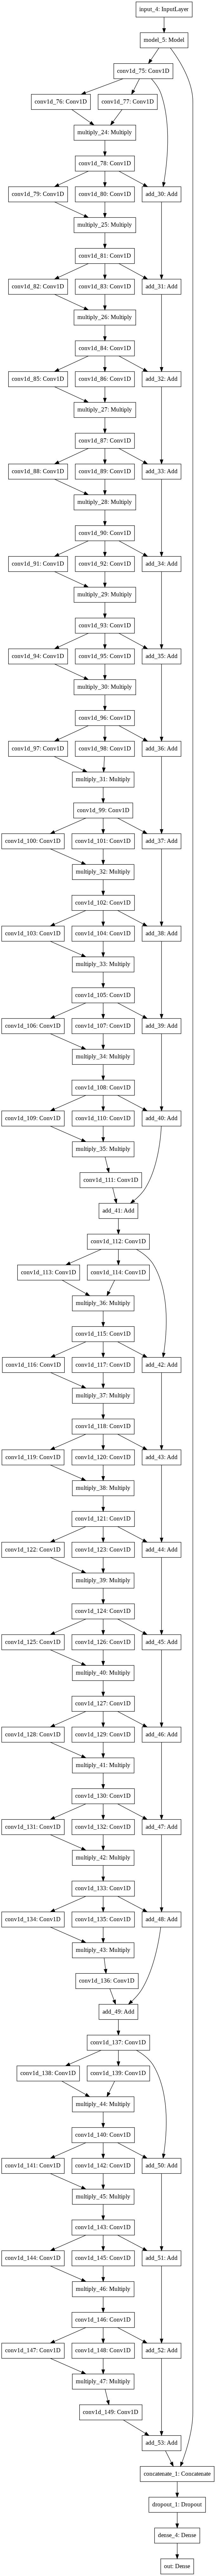

In [0]:
tf.keras.utils.plot_model(t)

In [0]:
EPOCHS = 320
NNBATCHSIZE = 16
GROUP_BATCH_SIZE = 4000
SEED = 321
LR = 0.01
SPLITS = 6

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)


In [0]:
def lr_schedule(epoch):
    if epoch < 20:
        lr = LR
    elif epoch < 30:
        lr = LR / 3
    elif epoch < 40:
        lr = LR / 5
    elif epoch < 50:
        lr = LR / 7
    elif epoch < 60:
        lr = LR / 9
    elif epoch < 70:
        lr = LR / 11
    elif epoch < 80:
        lr = LR / 13
    else:
        lr = LR / 100
    return lr

In [0]:
class MacroF1(Callback):
    def __init__(self, model, inputs, targets):
        self.model = model
        self.inputs = inputs
        self.targets = np.argmax(targets, axis = 2).reshape(-1)
        
    def on_epoch_end(self, epoch, logs):
        pred = np.argmax(self.model.predict(self.inputs), axis = 2).reshape(-1)
        score = f1_score(self.targets, pred, average = 'macro')
        print(f'F1 Macro Score: {score:.5f}')

In [0]:
def kaggleMatrics(t_true, y_pred):
    pred = np.argmax(y_pred, axis = 2).reshape(-1)
    score = f1_score(y_true, pred, average = 'macro')
    print(f'F1 Macro Score: {score:.5f}')
    return score 

In [0]:
def getCallbacks():
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=10, 
        verbose=1, restore_best_weights=True)

    return [early_stopping]
  


In [0]:
####################
# READING IN FILES
####################

def read_data():
    train = pd.read_csv(f'{PATH}/train_clean_kalman.csv', dtype={'time': np.float32, 'signal': np.float32, 'open_channels':np.int32})
    test  = pd.read_csv(f'{PATH}/test_clean_kalman.csv', dtype={'time': np.float32, 'signal': np.float32})
    sub  = pd.read_csv(f'{PATH}/sample_submission.csv', dtype={'time': np.float32})
    train_gm = pd.get_dummies(np.load(f'{PATH}/gm_train_22_5.npy'), prefix='gm')
    test_gm = pd.get_dummies(np.load(f'{PATH}/gm_test_22_5.npy'),  prefix='gm')
    train_k = pd.get_dummies(np.load(f'{PATH}/minibatch_kmeans_train.npy'),  prefix='knn')
    test_k = pd.get_dummies(np.load(f'{PATH}/minibatch_kmeans_test.npy'), prefix='knn')
    train = pd.concat([train, train_gm, train_k ],  axis=1)
    test = pd.concat([test, test_gm, test_k ],  axis=1)
    

    return train, test, sub

In [0]:

###########
# Normalization
###########

def batching(df, batch_size):
    df['group'] = df.groupby(df.index//batch_size, sort=False)['signal'].agg(['ngroup']).values
    df['group'] = df['group'].astype(np.uint16)
    return df

# normalize the data (standard scaler). We can also try other scalers for a better score!
def normalize(train, test):
    # train_input_mean = train.signal.mean()
    # train_input_sigma = train.signal.std()
    # train['signal'] = (train.signal - train_input_mean) / train_input_sigma
    # test['signal'] = (test.signal - train_input_mean) / train_input_sigma

    # train_input_mean = train.signal_o.mean()
    # train_input_sigma = train.signal_o.std()
    # train['signal_o'] = (train.signal_o - train_input_mean) / train_input_sigma
    # test['signal_o'] = (test.signal_o - train_input_mean) / train_input_sigma


    return train, test

In [0]:

###########
# FEATURES
###########
def lag_with_pct_change(df, windows):
    for window in windows:    
        df['signal_shift_pos_' + str(window)] = df.groupby('group')['signal'].shift(window).fillna(0)
        df['signal_shift_neg_' + str(window)] = df.groupby('group')['signal'].shift(-1 * window).fillna(0)
        df['signal_shift_pos_min_' + str(window)] = df['signal_shift_pos_' + str(window)] - df['signal']
        df['signal_shift_pos_min_' + str(window)] = df['signal_shift_pos_' + str(window)] - df['signal']

    return df

# main module to run feature engineering. Here you may want to try and add other features and check if your score imporves :).
def run_feat_engineering(df, batch_size):
    # create batches
    df = batching(df, batch_size = batch_size)


    return df

In [0]:
# fillna with the mean and select features for training
def feature_selection(train, test):
    features = [col for col in train.columns if col not in ['index', 'group', 'open_channels', 'time']]
    train = train.replace([np.inf, -np.inf], np.nan)
    test = test.replace([np.inf, -np.inf], np.nan)
    for feature in features:
        feature_mean = pd.concat([train[feature], test[feature]], axis = 0).mean()
        train[feature] = train[feature].fillna(feature_mean)
        test[feature] = test[feature].fillna(feature_mean)
    return train, test, features

In [0]:
train, test, sample_submission = read_data()
train, test = normalize(train, test)
print('Reading and Normalizing Data Completed')
#  class_weights = get_class_weight(train.open_channels)       
print('Creating Features')
print('Feature Engineering Started...')
train = run_feat_engineering(train, batch_size = GROUP_BATCH_SIZE)  
test = run_feat_engineering(test, batch_size = GROUP_BATCH_SIZE)
train, test, features = feature_selection(train, test)

Reading and Normalizing Data Completed
Creating Features
Feature Engineering Started...


In [0]:
train.shape, test.shape

((5000000, 48), (2000000, 47))

In [0]:
oof_ = np.zeros((len(train), 11)) # build out of folds matrix with 11 columns, they represent our target variables classes (from 0 to 10)
preds_ = np.zeros((len(test), 11))
target = ['open_channels']
group = train['group']
kf = GroupKFold(n_splits=5)
splits = [x for x in kf.split(train, train[target], group)]
new_splits = []
if not os.path.exists('Models'):
    os.makedirs('Models')
    
for sp in splits:
    new_split = []
    new_split.append(np.unique(group[sp[0]]))
    new_split.append(np.unique(group[sp[1]]))
    new_split.append(sp[1])    
    new_splits.append(new_split)

In [0]:


feats= features  
tr = pd.concat([pd.get_dummies(train.open_channels), train[['group']]], axis=1)

tr.columns = ['target_'+str(i) for i in range(11)] + ['group']
target_cols = ['target_'+str(i) for i in range(11)]

In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
SPLITS = 5

In [0]:
train_tr = np.array(list(tr.groupby('group').apply(lambda x: x[target_cols].values))).astype(np.float32)
train = np.array(list(train.groupby('group').apply(lambda x: x[feats].values)))
test = np.array(list(test.groupby('group').apply(lambda x: x[feats].values)))


In [0]:
LR = 0.0001
nn_epochs = 20
nn_batch_size = 16*1

In [0]:
model_name = 'model_d21_f1_bn'

0
1
2
3
4
Our training dataset shape is (1000, 4000, 45)
Our validation dataset shape is (250, 4000, 45)
(None, 45)
Epoch 1/20
F1 Macro Score: 0.94278
F1 Macro Score: 0.94116

Epoch 00001: val_loss improved from inf to 0.01833, saving model to /content/drive/My Drive/Kaggle/ion_data//model_model_d21_f1_bn_4_chk.h5
63/63 - 76s - loss: 0.0285 - accuracy: 0.9576 - val_loss: 0.0183 - val_accuracy: 0.9696
Epoch 2/20
F1 Macro Score: 0.94268
F1 Macro Score: 0.94084

Epoch 00002: val_loss improved from 0.01833 to 0.01819, saving model to /content/drive/My Drive/Kaggle/ion_data//model_model_d21_f1_bn_4_chk.h5
63/63 - 67s - loss: 0.0245 - accuracy: 0.9624 - val_loss: 0.0182 - val_accuracy: 0.9696
Epoch 3/20
F1 Macro Score: 0.94265
F1 Macro Score: 0.94089

Epoch 00003: val_loss improved from 0.01819 to 0.01811, saving model to /content/drive/My Drive/Kaggle/ion_data//model_model_d21_f1_bn_4_chk.h5
63/63 - 67s - loss: 0.0231 - accuracy: 0.9642 - val_loss: 0.0181 - val_accuracy: 0.9696
Epoch 4/20
F

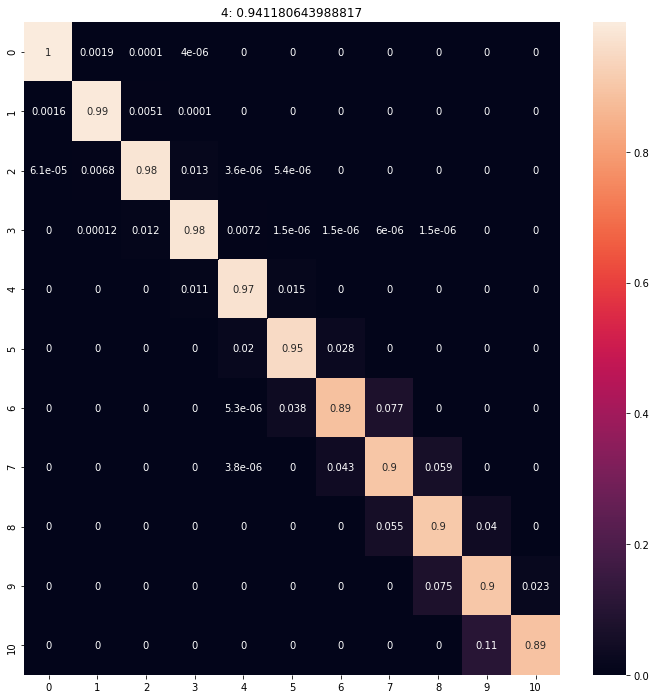

Training completed. oof macro f1 score : 0.69121


In [0]:
for n_fold, (tr_idx, val_idx, val_orig_idx) in enumerate(new_splits[0:], start=0):

    print (n_fold)
    if n_fold != 4:
        continue
    train_x, train_y = train[tr_idx], train_tr[tr_idx]
    valid_x, valid_y = train[val_idx], train_tr[val_idx]
    print(f'Our training dataset shape is {train_x.shape}')
    print(f'Our validation dataset shape is {valid_x.shape}')

    gc.collect()
    shape_ = (None, train_x.shape[2])  # input is going to be the number of feature we are using (dimension 2 of 0, 1, 2)
    print (shape_)
    model = wave_rnn_net(shape_,n_fold )
    opt = Adam(lr = LR)
    # opt = tfa.optimizers.SWA(opt)
    model.compile(loss = tfa.losses.sigmoid_focal_crossentropy, optimizer = opt, metrics = ['accuracy'])
    model.load_weights(f'{PATH}/model_d21_f1_{n_fold}.h5')
    
        # using our lr_schedule function
    cb_lr_schedule = LearningRateScheduler(lr_schedule)
    chk_point = keras.callbacks.ModelCheckpoint(
        filepath= f'{PATH}/model_{model_name}_{n_fold}_chk.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', verbose=1)
    # onecycle = OneCycleScheduler(len(train_x) // nn_batch_size * nn_epochs, max_rate=0.05)
    call_backs = [  MacroF1(model, train_x, train_y),  MacroF1(model, valid_x, valid_y), chk_point ] + getCallbacks()
    if True:
    
        model.fit(train_x,train_y,
              epochs = nn_epochs,
              callbacks = call_backs, # adding custom evaluation metric for each epoch
              batch_size = nn_batch_size,verbose = 2,
            #   sample_weight = d_class_weights,
            #   sample_weight_mode="temporal",
              validation_data = (valid_x,valid_y))
        model.save_weights(f'{PATH}/{model_name}_{n_fold}.h5')
        
    preds_f = model.predict(valid_x)
    f1_score_ = f1_score(np.argmax(valid_y, axis=2).reshape(-1),  np.argmax(preds_f, axis=2).reshape(-1), average = 'macro') # need to get the class with the biggest probability
    print(f'Training fold {n_fold + 1} completed. macro f1 score : {f1_score_ :1.5f}')
    preds_f = preds_f.reshape(-1, preds_f.shape[-1])
    oof_[val_orig_idx,:] += preds_f
    te_preds = model.predict(test)
    te_preds = te_preds.reshape(-1, te_preds.shape[-1])           
    preds_ += te_preds / SPLITS
    gc.collect()
    plt.figure(figsize=(12,12));
    sns.heatmap(confusion_matrix(np.argmax(train_tr, axis=2).reshape(-1), np.argmax(model.predict(train), axis=2).reshape(-1), normalize='true' ), annot=True);
    plt.title(f'{n_fold}: {f1_score_}')
    plt.show()

    # calculate the oof macro f1_score
f1_score_ = f1_score(np.argmax(train_tr, axis = 2).reshape(-1),  np.argmax(oof_, axis = 1), average = 'macro') # axis 2 for the 3 Dimension array and axis 1 for the 2 Domension Array (extracting the best class)
print(f'Training completed. oof macro f1 score : {f1_score_:1.5f}')
sample_submission['open_channels'] = np.argmax(preds_, axis = 1).astype(int)
sample_submission.to_csv(f'{PATH}/model_{model_name}_{f1_score_}.csv', index=False, float_format='%.4f')

In [0]:
preds_ = 0

0
Our training dataset shape is (1000, 4000, 45)
Our validation dataset shape is (250, 4000, 45)
(None, 45)
Training fold 1 completed. macro f1 score : 0.94149


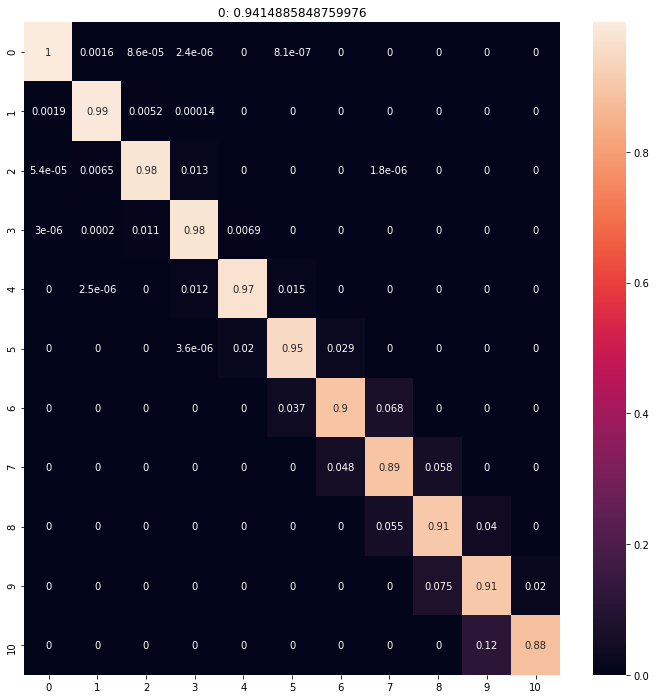

1
Our training dataset shape is (1000, 4000, 45)
Our validation dataset shape is (250, 4000, 45)
(None, 45)
Training fold 2 completed. macro f1 score : 0.94263


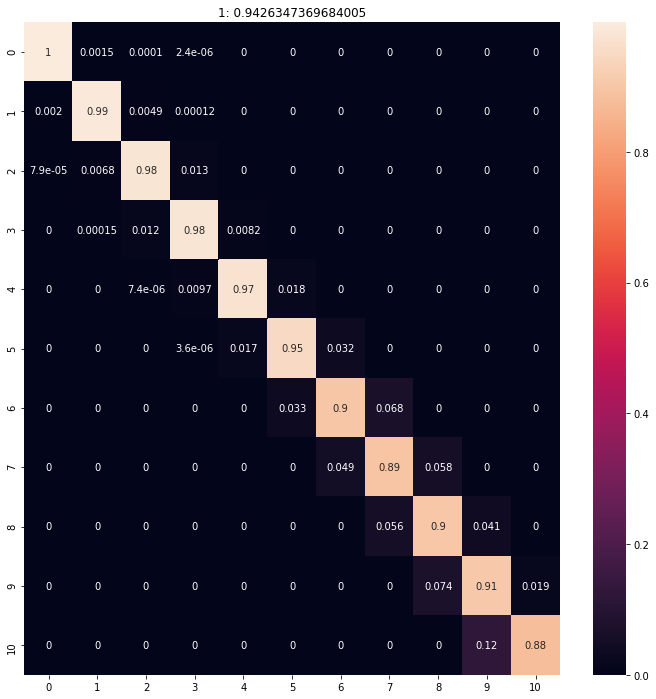

2
Our training dataset shape is (1000, 4000, 45)
Our validation dataset shape is (250, 4000, 45)
(None, 45)
Training fold 3 completed. macro f1 score : 0.94069


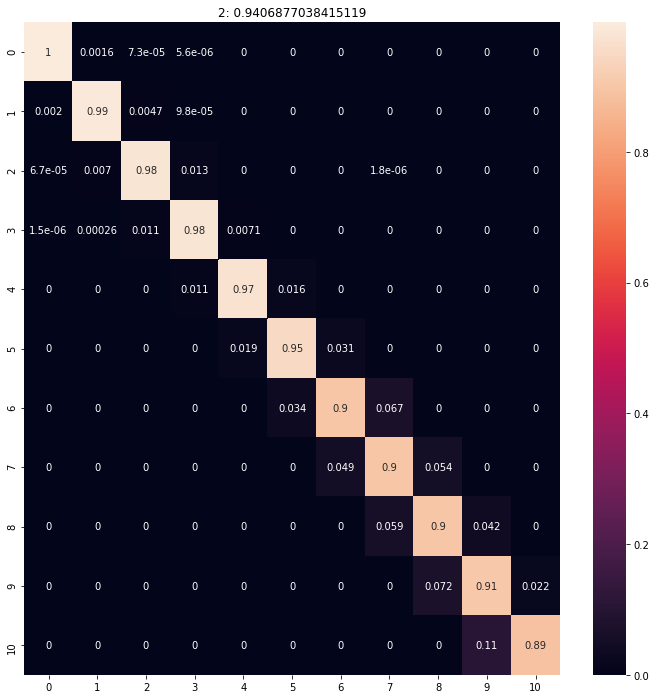

3
Our training dataset shape is (1000, 4000, 45)
Our validation dataset shape is (250, 4000, 45)
(None, 45)
Training fold 4 completed. macro f1 score : 0.94078


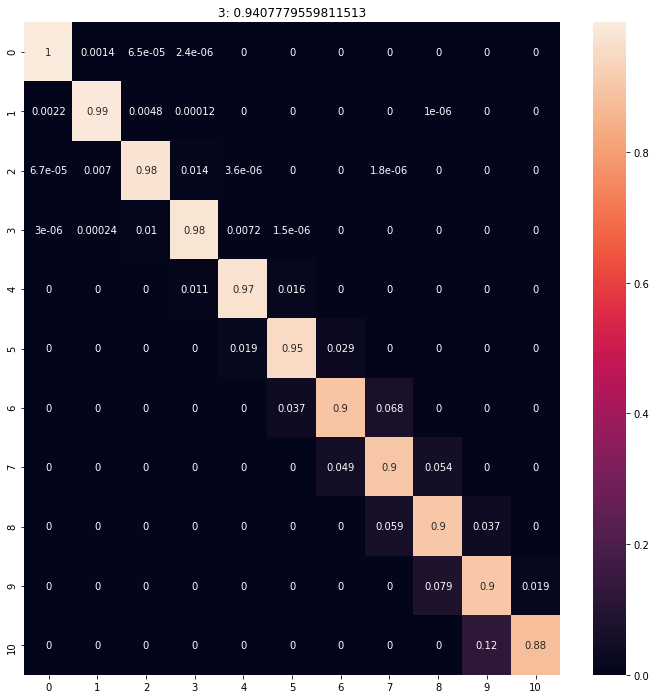

4
Our training dataset shape is (1000, 4000, 45)
Our validation dataset shape is (250, 4000, 45)
(None, 45)
Training fold 5 completed. macro f1 score : 0.94118


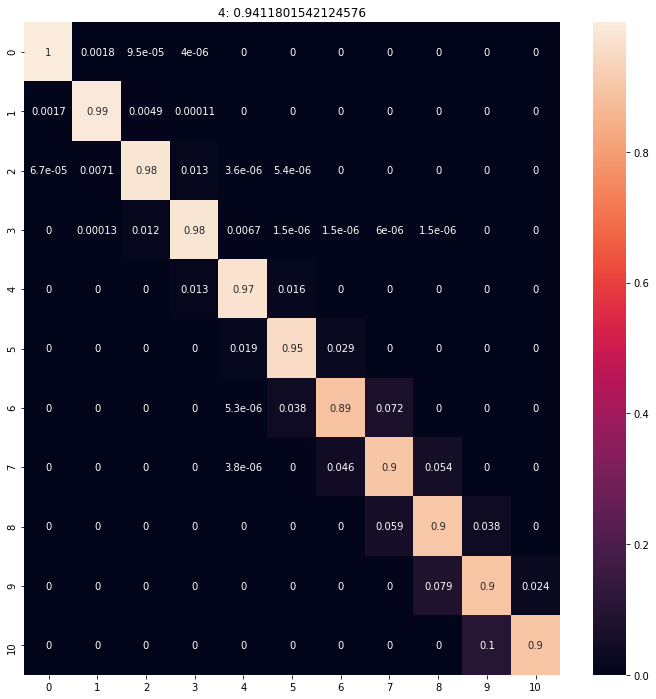

Training completed. oof macro f1 score : 0.94150


In [0]:
for n_fold, (tr_idx, val_idx, val_orig_idx) in enumerate(new_splits[0:], start=0):

    print (n_fold)

    train_x, train_y = train[tr_idx], train_tr[tr_idx]
    valid_x, valid_y = train[val_idx], train_tr[val_idx]
    print(f'Our training dataset shape is {train_x.shape}')
    print(f'Our validation dataset shape is {valid_x.shape}')

    gc.collect()
    shape_ = (None, train_x.shape[2])  # input is going to be the number of feature we are using (dimension 2 of 0, 1, 2)
    print (shape_)
    model = wave_rnn_net(shape_,n_fold )
    opt = Adam(lr = LR)
    # opt = tfa.optimizers.SWA(opt)
    model.compile(loss = tfa.losses.sigmoid_focal_crossentropy, optimizer = opt, metrics = ['accuracy'])
    model.load_weights(f'{PATH}/model_{model_name}_{n_fold}_chk.h5')

        
    preds_f = model.predict(valid_x)
    f1_score_ = f1_score(np.argmax(valid_y, axis=2).reshape(-1),  np.argmax(preds_f, axis=2).reshape(-1), average = 'macro') # need to get the class with the biggest probability
    print(f'Training fold {n_fold + 1} completed. macro f1 score : {f1_score_ :1.5f}')
    preds_f = preds_f.reshape(-1, preds_f.shape[-1])
    oof_[val_orig_idx,:] += preds_f
    te_preds = model.predict(test)
    te_preds = te_preds.reshape(-1, te_preds.shape[-1])           
    preds_ += te_preds / SPLITS
    gc.collect()
    plt.figure(figsize=(12,12));
    sns.heatmap(confusion_matrix(np.argmax(train_tr, axis=2).reshape(-1), np.argmax(model.predict(train), axis=2).reshape(-1), normalize='true' ), annot=True);
    plt.title(f'{n_fold}: {f1_score_}')
    plt.show()

    # calculate the oof macro f1_score
f1_score_ = f1_score(np.argmax(train_tr, axis = 2).reshape(-1),  np.argmax(oof_, axis = 1), average = 'macro') # axis 2 for the 3 Dimension array and axis 1 for the 2 Domension Array (extracting the best class)
print(f'Training completed. oof macro f1 score : {f1_score_:1.5f}')
sample_submission['open_channels'] = np.argmax(preds_, axis = 1).astype(int)
sample_submission.to_csv(f'{PATH}/model_{model_name}_{f1_score_}.csv', index=False, float_format='%.4f')

In [0]:
!mkdir -p ~/.kaggle
!cp /content/drive/My\ Drive/Kaggle/ion_data/kaggle.json ~/.kaggle/

In [0]:
f'{PATH}/model_{model_name}_{f1_score_}.csv'

'/content/drive/My Drive/Kaggle/ion_data//model_model_d21_f1_bn_0.9415009295265815.csv'

In [0]:
# !kaggle competitions submit -c liverpool-ion-switching -f  /content/drive/My\ Drive/Kaggle/ion_data/{model_wave_rnn_d21_}0.941752216347603.csv -m 'full training with concat'

In [0]:
!kaggle competitions submit -c liverpool-ion-switching -f  /content/drive/My\ Drive/Kaggle/ion_data/model_model_d21_f1_bn_0.9415009295265815.csv  -m 'full training with f1Loss'

100% 21.0M/21.0M [00:05<00:00, 4.17MB/s]
Successfully submitted to University of Liverpool - Ion Switching